In this notebook we investigate time series data and time trends in the SEP data

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from datetime import datetime, date
import os
import zipfile

In [2]:
# Set up some directory info, and figure export path
PROJECT_ROOT_DIR = '../../../'
NOTEBOOK_ID = 'Time_Series_Data'
FIGURE_EXPORT_PATH = os.path.join(PROJECT_ROOT_DIR, "analyses/team04/mg/figures", NOTEBOOK_ID)
os.makedirs(FIGURE_EXPORT_PATH, exist_ok = True)

In [3]:
# Define figure export
def save_fig(fig_id, tight_layout=True, fig_extension = "png", resolution = 300):
    path = os.path.join(FIGURE_EXPORT_PATH, fig_id + '.' + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)

In [4]:
# Set up some plotting conveniences/settings
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [5]:
# Original data path
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data/data.zip")
data = zipfile.ZipFile(DATA_PATH) 
# Site location path
LAT_LON_PATH = os.path.join(PROJECT_ROOT_DIR, "analyses/team04/mg/data/sep_site_outrigger_LATLON_updated.csv")

###########
# Load data
###########

# Needle Data
pp_sep_site_exchanges = pd.read_csv(data.open(r'data/pp_sep_site_exchanges.csv', pwd = b'*$1Y5.2,|sG$'))
pp_sep_site_participants = pd.read_csv(data.open(r'data/pp_sep_site_participants.csv', pwd = b'*$1Y5.2,|sG$'))

# Site location data
lat_lon = pd.read_csv(LAT_LON_PATH)

# Investigate SEP Site Exchange Data

In [6]:
pp_sep_site_exchanges.head(5)

,site_id,visit_month,syringes_returned,syringes_dispensed,no_exchanging_for
0,1.0,2019-01-01,5625,6175,48
1,1.0,2019-02-01,12700,13960,89
2,1.0,2019-03-01,8862,10470,76
3,1.0,2019-04-01,6130,7070,64
4,1.0,2019-05-01,9369,9830,66


In [7]:
pp_sep_site_participants.head(5)

,site_id,visit_month,count_distinct_participants
0,1,2019-01-01,42
1,1,2019-10-01,51
2,1,2019-11-01,73
3,1,2019-12-01,54
4,1,2019-02-01,74


In [8]:
pp_sep_site_exchanges.dtypes

site_id               float64
visit_month            object
syringes_returned       int64
syringes_dispensed      int64
no_exchanging_for       int64
dtype: object

In [9]:
# Change site_id dtype for merging
pp_sep_site_participants["site_id"] =pp_sep_site_participants["site_id"].astype('float64')

In [10]:
pp_sep_site_participants.head(5)

,site_id,visit_month,count_distinct_participants
0,1.0,2019-01-01,42
1,1.0,2019-10-01,51
2,1.0,2019-11-01,73
3,1.0,2019-12-01,54
4,1.0,2019-02-01,74


In [11]:
# Let's merge these two dataframes:
pp_sep_site = pd.merge(pp_sep_site_exchanges, pp_sep_site_participants, how = 'inner', on =["site_id", "visit_month"])

In [12]:
pp_sep_site.head(5)

,site_id,visit_month,syringes_returned,syringes_dispensed,no_exchanging_for,count_distinct_participants
0,1.0,2019-01-01,5625,6175,48,42
1,1.0,2019-02-01,12700,13960,89,74
2,1.0,2019-03-01,8862,10470,76,61
3,1.0,2019-04-01,6130,7070,64,49
4,1.0,2019-05-01,9369,9830,66,57


In [13]:
pp_sep_site["site_id"].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       17., 18., 22., 99.])

In [14]:
pp_sep_site["visit_month"].unique()

array(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
       '2019-05-01', '2019-06-01', '2019-08-01', '2019-09-01',
       '2019-10-01', '2019-11-01', '2019-12-01', '2019-07-01'],
      dtype=object)

In [15]:
# Convert dates into datetime format
pp_sep_site["visit_month"] = pd.to_datetime(pp_sep_site["visit_month"])

In [65]:
# Definition to plot time series by site_id (if localized =True)
# or to plot time series aggregated over all sites (if localized=False)


# Provide features and dates as list:
def sep_site_time_series(df, site_id, features, localized = True):
    if localized:
        dates = df.loc[df["site_id"]==site_id,["visit_month"]]
        fig, ax = plt.subplots(figsize=(10,4))
        color_code_it = 0
        color_code_list = ["lightblue", 'orange', 'red', 'yellow', 'green']
        for feature in features:
            ax.plot(dates, df.loc[df["site_id"]==site_id,[feature] ],color = color_code_list[color_code_it],label =f'{feature}')
            color_code_it +=1
        # Add labels
        ax.set_ylabel('Value')
        ax.set_xlabel('Month')
        ax.set_title(f'SEP site time series site {site_id}')
        ax.legend()
    else:
        grouped = df.groupby(['visit_month'], as_index = False).sum()
        dates = grouped["visit_month"]
        fig, ax = plt.subplots(figsize=(10,4))
        color_code_it = 0
        color_code_list = ["lightblue", 'orange', 'red', 'yellow', 'green']
        for feature in features:
            ax.plot(dates, grouped[feature],color = color_code_list[color_code_it],label =f'{feature}')
            color_code_it +=1   
        # Add labels
        ax.set_ylabel('Value')
        ax.set_xlabel('Month')
        ax.set_title(' Aggregated SEP site time series')
        ax.legend()


Saving figure Site 1 Time Series


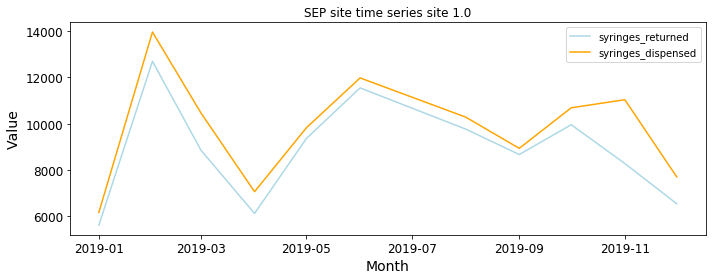

In [66]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot syringes returned and dispensed at site 1
features = ["syringes_returned", "syringes_dispensed"]
sep_site_time_series(pp_sep_site, 1.,features)
save_fig("Site 1 Time Series")

Saving figure Aggregated Sites Time Series


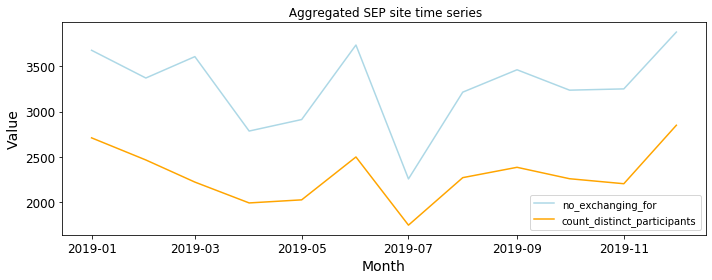

In [67]:
# Plot count of individuals and number exchanging for over all sites
features = ["no_exchanging_for", "count_distinct_participants"]
sep_site_time_series(pp_sep_site, 6.,features, localized = False)
save_fig("Aggregated Sites Time Series")

Saving figure Aggregated Sites Time Series 2


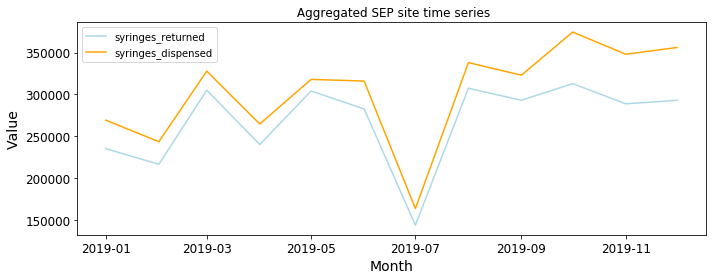

In [68]:
# Plot count of syringes returned and syringes dispensed over all sites
features = ["syringes_returned", "syringes_dispensed"]
sep_site_time_series(pp_sep_site, 6.,features, localized = False)
save_fig("Aggregated Sites Time Series 2")

Question: What happened in in July, 2019? Is the data innaccurate, or did activity really decline heavily? If the latter, can we predict such events, and would doing so be useful?

## Some possible models for syringe use population estimates, and SEP demand forecast

In [70]:
lat_lon.head()

,site_id,site_name,site_location,address,Lat,Lon,description,geometry
0,1,Mobile,3rd @ Girard,NaN,39.969770,-75.141520,Mobile Site,POINT (-75.14152 39.96977)
1,2,Mobile,10th @ Fairmount,NaN,39.965370,-75.154100,Mobile Site,POINT (-75.1541 39.96537)
2,3,Mobile,11th @ Indiana,NaN,39.997810,-75.148240,Mobile Site,POINT (-75.14824 39.99781)
3,4,Mobile,13th @ Washington,NaN,39.937610,-75.164590,Mobile Site,POINT (-75.16459 39.93761)
4,5,Headquarters - Friday,2913-15 Kensington Ave,2913-15 Kensington Ave,39.992885,-75.119643,In Building Exchange,POINT (-75.119643 39.992885)


In [72]:
pp_zipcode_metrics = pd.read_csv(data.open(r'data/pp_refill_zipcode_metrics.csv', pwd = b'*$1Y5.2,|sG$'))
pp_zipcode_metrics.head()

,participant_zip,avg_outcome_ems,avg_outcome_police,avg_outcome_ed,avg_outcome_death,avg_outcome_unk,avg_outcome_ok,avg_od_drug_heroin,avg_od_drug_cocaine,avg_od_drug_fentanyl,avg_od_drug_unknown,avg_od_drug_other,avg_od_present_breath,avg_od_present_unresponsive,avg_od_present_coloring,avg_od_present_other,avg_cpr_used,n_observations
0,19111.0,0.366667,0.150000,0.200000,0.000000,0.150000,0.700000,0.517241,0.068966,0.310345,0.241379,0.161290,0.642857,0.750000,0.678571,0.000000,0.600000,31
1,19120.0,0.318182,0.210526,0.052632,0.000000,0.052632,0.526316,0.695652,0.130435,0.652174,0.000000,0.000000,0.304348,0.565217,0.478261,0.043478,0.428571,26
2,19122.0,0.187500,0.115385,0.000000,0.000000,0.076923,0.769231,0.366667,0.033333,0.366667,0.266667,0.093750,0.387097,0.419355,0.322581,0.225806,0.333333,36
3,19124.0,0.358209,0.176471,0.125000,0.026144,0.071895,0.581699,0.820513,0.200000,0.528205,0.061538,0.088235,0.438144,0.541237,0.556701,0.030928,0.453333,219
4,19125.0,0.206186,0.115942,0.072464,0.043478,0.202899,0.608696,0.648352,0.109890,0.494505,0.098901,0.140000,0.377778,0.511111,0.555556,0.011236,0.419355,102


In [74]:
data.namelist()

['data/',
 'data/hf_samsha_providers.csv',
 'data/pp_refill_events.csv',
 'data/pp_sep_site_exchanges.csv',
 'data/dph_od_resident_counts.csv',
 'data/.DS_Store',
 'data/hf_physician_locator.csv',
 'data/dph_dash_ems_naloxone_zip.csv',
 'data/pp_refill_zipcode_metrics.csv',
 'data/dph_dash_n_ed_transfers.csv',
 'data/dph_dash_ems_naloxone_sex.csv',
 'data/pp_sep_site_participants.csv',
 'data/dph_dash_n_naloxone_admins.csv',
 'data/dph_od_incident_counts.csv',
 'data/dph_dash_ems_naloxone_age.csv',
 'data/hf_samsha_programs.csv']

In [86]:
od_incident_counts = pd.read_csv(data.open(r'data/dph_od_incident_counts.csv', pwd = b'*$1Y5.2,|sG$'))
od_incident_counts.head()

,ZIPCODE,X2014Q1,X2014Q2,X2014Q3,X2014Q4,X2015Q1,X2015Q2,X2015Q3,X2015Q4,X2016Q1,...,X2016Q3,X2016Q4,X2017Q1,X2017Q2,X2017Q3,X2017Q4,X2018Q1,X2018Q2,X2018Q3,X2018Q4
0,19102,0,0,0,0,0,0,<6,0,<6,...,0,<6,<6,0,<6,<6,0,<6,<6,0
1,19103,<6,0,<6,0,0,0,0,0,0,...,<6,<6,<6,<6,<6,0,<6,<6,<6,<6
2,19104,<6,<6,<6,6,6,6,<6,<6,<6,...,<6,6,<6,6,9,8,<6,7,<6,8
3,19106,0,0,<6,<6,<6,0,0,<6,<6,...,<6,<6,<6,<6,<6,<6,<6,<6,<6,<6
4,19107,<6,<6,<6,<6,<6,<6,0,<6,6,...,<6,<6,<6,<6,<6,<6,<6,<6,<6,6
